### Data analysis for DIA-NN and Full-DIA result on Plasma dataset

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
plt.style.use('default')
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
plt.rcParams['font.family'] = 'Arial'

#### Check analysis time

In [2]:
report_dir = Path('../../reports/Plasma')

# diann
with open(report_dir/'diann_220'/'report.log.txt') as f:
    lines = f.readlines()
    time_str = lines[-2].split(' ')[0][1:-1]
    total_minutes = int(time_str.split(':')[0]) + int(
        time_str.split(':')[-1]) / 60
    n = int(lines[-20].split(' ')[-2])
    t_mean = total_minutes / n
print(f'diann, #runs: {n}, Minutes/Run: {t_mean:.2f}')

# fulldia
from datetime import timedelta
with open(report_dir/'full_100'/'report.log.txt') as f:
    lines = f.readlines()
    time_str = lines[-1].split(' ')[0][:-1]
    h, m, s = map(int, time_str.split(':'))
    duration = timedelta(hours=h, minutes=m, seconds=s)
    total_minutes = duration.total_seconds()/60.
    n = int(lines[-10].split(' ')[2])
    t_mean = total_minutes / n
print(f'fulldia, #runs: {n}, Minutes/Run: {t_mean:.2f}')

diann, #runs: 15, Minutes/Run: 58.84
fulldia, #runs: 15, Minutes/Run: 37.08


#### Check the report.parquet

In [3]:
df_raw1 = pd.read_parquet(report_dir/'diann_220'/'report.parquet', engine='fastparquet')
pgs1 = set(df_raw1[df_raw1['Global.PG.Q.Value'] < 0.01]['Protein.Group'])
prs1 = set(df_raw1[df_raw1['Global.Q.Value'] < 0.01]['Precursor.Id'])
print(f'diann, Global n_prs: {len(prs1)}, Global n_pgs: {len(pgs1)}')

df_raw2 = pd.read_parquet(report_dir/'full_100'/'report.parquet')
pgs2 = set(df_raw2[df_raw2['Global.PG.Q.Value'] < 0.01]['Protein.Group'])
prs2 = set(df_raw2[df_raw2['Global.Q.Value'] < 0.01]['Precursor.Id'])
print(f'fulldia, Global n_prs: {len(prs2)}, Global n_pgs: {len(pgs2)}')

gain_pr = (len(prs2) - len(prs1)) / len(prs1)
gain_pg = (len(pgs2) - len(pgs1)) / len(pgs1)
print(f'gain_pr: {gain_pr:.2f}, gain_pg: {gain_pg:.2f}')

diann, Global n_prs: 12482, Global n_pgs: 1240
fulldia, Global n_prs: 14312, Global n_pgs: 1256
gain_pr: 0.15, gain_pg: 0.01


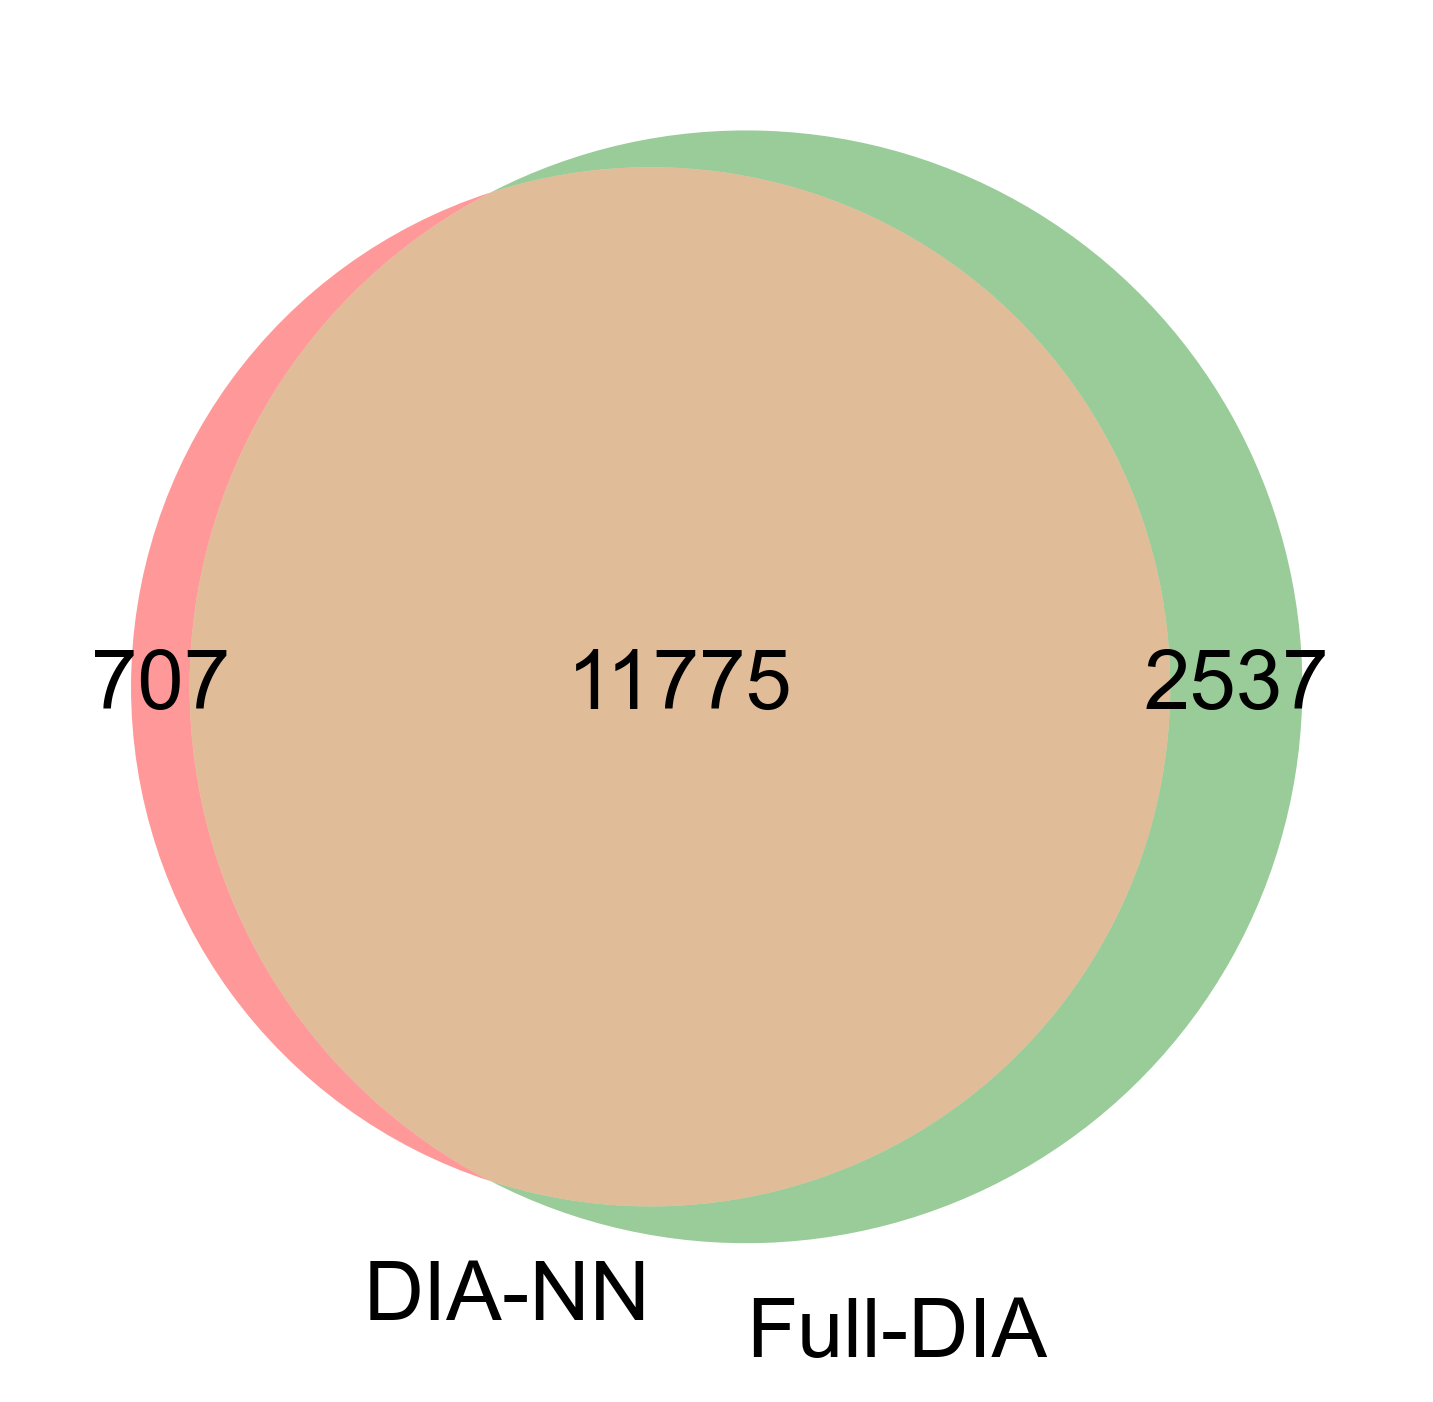

In [4]:
# venn for pr
from matplotlib_venn import venn2
v = venn2([prs1, prs2], ['DIA-NN', 'Full-DIA'])
for t in v.set_labels + v.subset_labels:
    if t: t.set_fontsize(20)
plt.tight_layout()
plt.show()

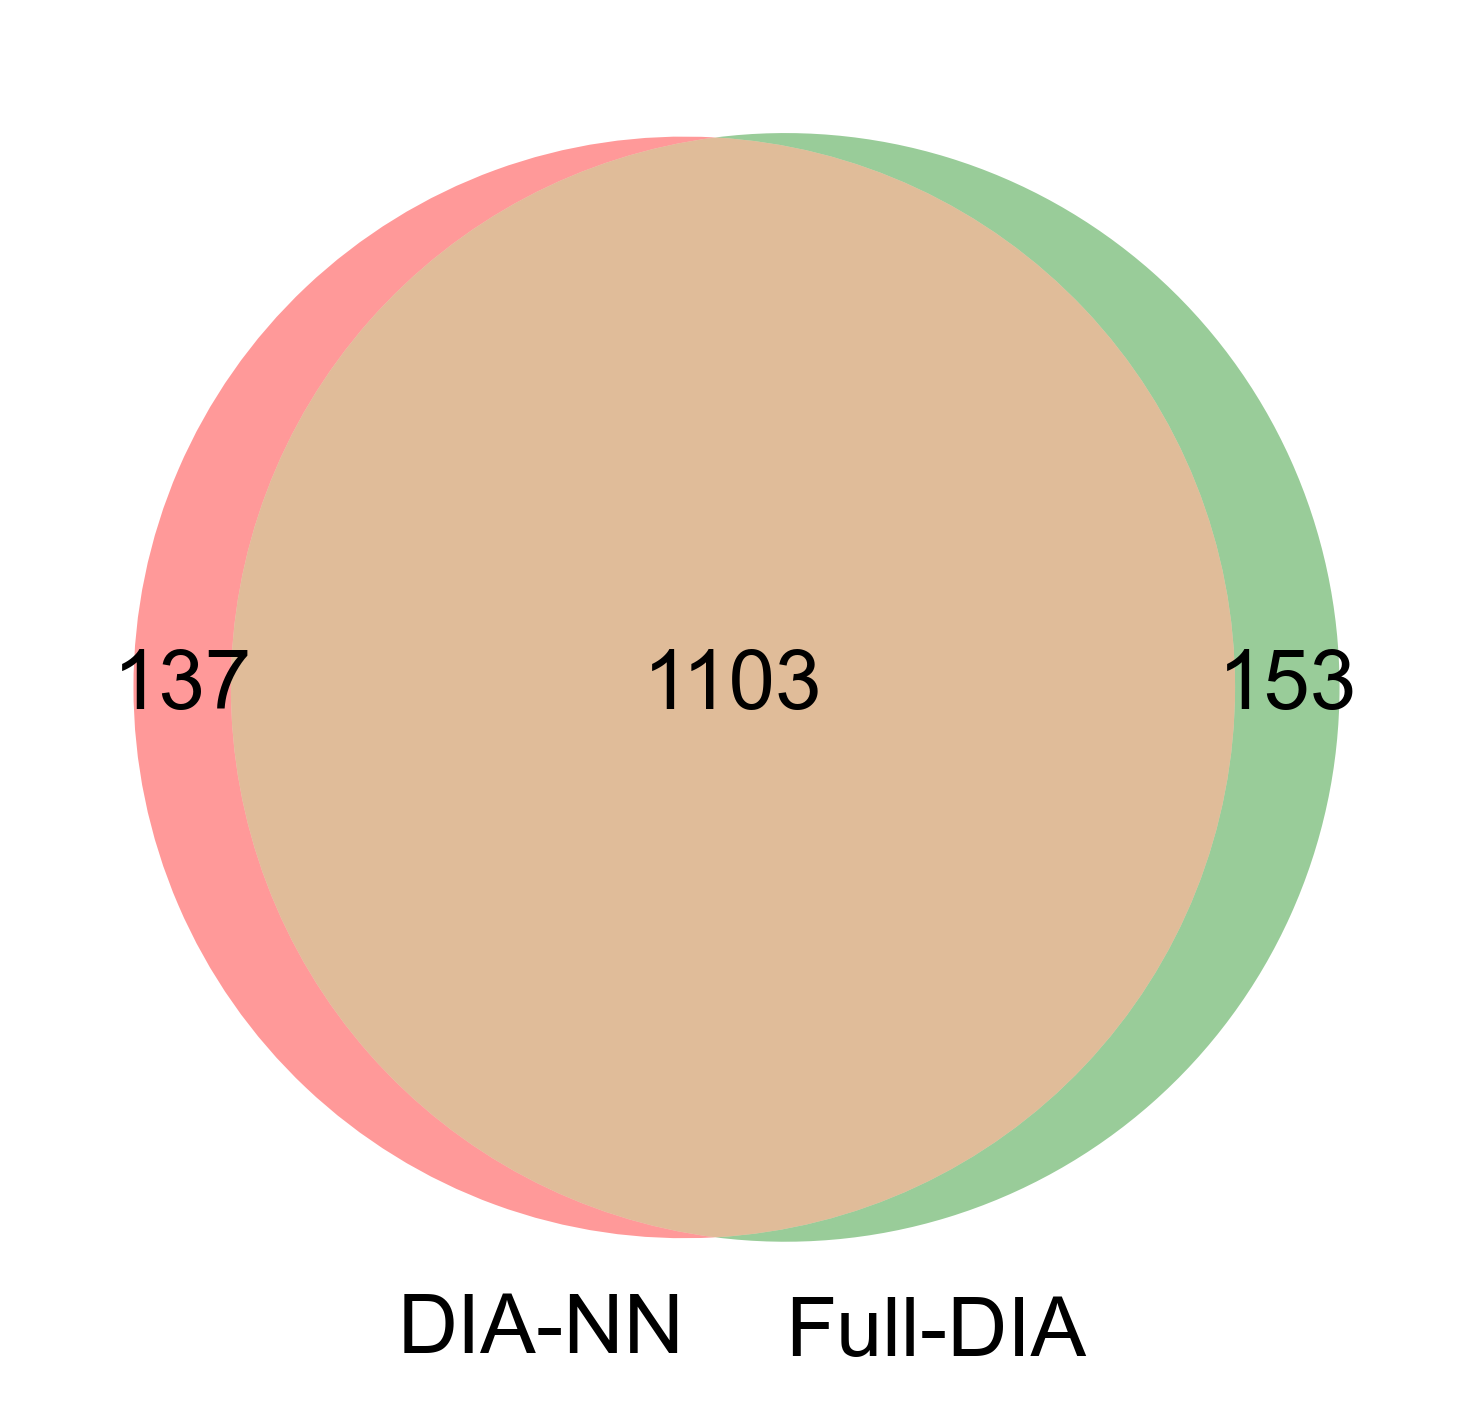

In [5]:
# venn for pg
v = venn2([pgs1, pgs2], ['DIA-NN', 'Full-DIA'])
for t in v.set_labels + v.subset_labels:
    if t: t.set_fontsize(20)
plt.tight_layout()
plt.show()

In [6]:
# append species
df_raw1['species'] = df_raw1['Protein.Names'].apply(
        lambda row: ';'.join(set([part.split('_')[1] for part in row.split(';')]))
    )
df_raw1 = df_raw1[df_raw1['species'].str.count(';') == 0]
df_raw2['species'] = df_raw2['Protein.Names'].apply(
        lambda row: ';'.join(set([part.split('_')[1] for part in row.split(';')]))
    )
df_raw2 = df_raw2[df_raw2['species'].str.count(';') == 0]

In [7]:
# calculating the external FDR
df_plot = pd.DataFrame()
df_plot['Method'] = np.repeat(['diann', 'fulldia'], 4)
df_plot['Level'] = ['pr', 'pr', 'pg', 'pg'] * 2
df_plot['Metric'] = ['TP', 'FP'] * 4
count_v = []
for i, row in df_plot.iterrows():
    method, level, metric = row['Method'], row['Level'], row['Metric']
    if (method == 'diann') and (level == 'pr'):
        df = df_raw1[df_raw1['Global.Q.Value'] < 0.01].copy()
        df['id'] = df['Precursor.Id']
    if (method == 'diann') and (level == 'pg'):
        df = df_raw1[df_raw1['Global.PG.Q.Value'] < 0.01].copy()
        df['id'] = df['Protein.Group']
    if (method == 'fulldia') and (level == 'pr'):
        df = df_raw2[df_raw2['Global.Q.Value'] < 0.01].copy()
        df['id'] = df['Precursor.Id']
    if (method == 'fulldia') and (level == 'pg'):
        df = df_raw2[df_raw2['Global.PG.Q.Value'] < 0.01].copy()
        df['id'] = df['Protein.Group']
    df = df[['id', 'species']].drop_duplicates()
    if metric == 'TP':
        count_v.append(sum(df['species'] == 'HUMAN'))
    else:
        count_v.append(sum(df['species'] == 'ARATH'))
df_plot['Count'] = count_v
df_plot["Level_Metric"] = df_plot["Level"] + "_" + df_plot["Metric"]
tp_values = df_plot[df_plot['Metric'] == 'TP'].set_index(['Method', 'Level'])['Count']
df_plot['Display_Value'] = df_plot.apply(
    lambda row: (
        f'{row.Count}\n({row.Count/tp_values.loc[(row.Method, row.Level)]*100:.1f}%)' if row.Metric == 'FP' else f'{row.Count}'
    ),
    axis=1
)
df_plot.copy()

,Method,Level,Metric,Count,Level_Metric,Display_Value
0,diann,pr,TP,12440,pr_TP,12440
1,diann,pr,FP,37,pr_FP,37\n(0.3%)
2,diann,pg,TP,1228,pg_TP,1228
3,diann,pg,FP,9,pg_FP,9\n(0.7%)
4,fulldia,pr,TP,14120,pr_TP,14120
5,fulldia,pr,FP,189,pr_FP,189\n(1.3%)
6,fulldia,pg,TP,1243,pg_TP,1243
7,fulldia,pg,FP,13,pg_FP,13\n(1.0%)


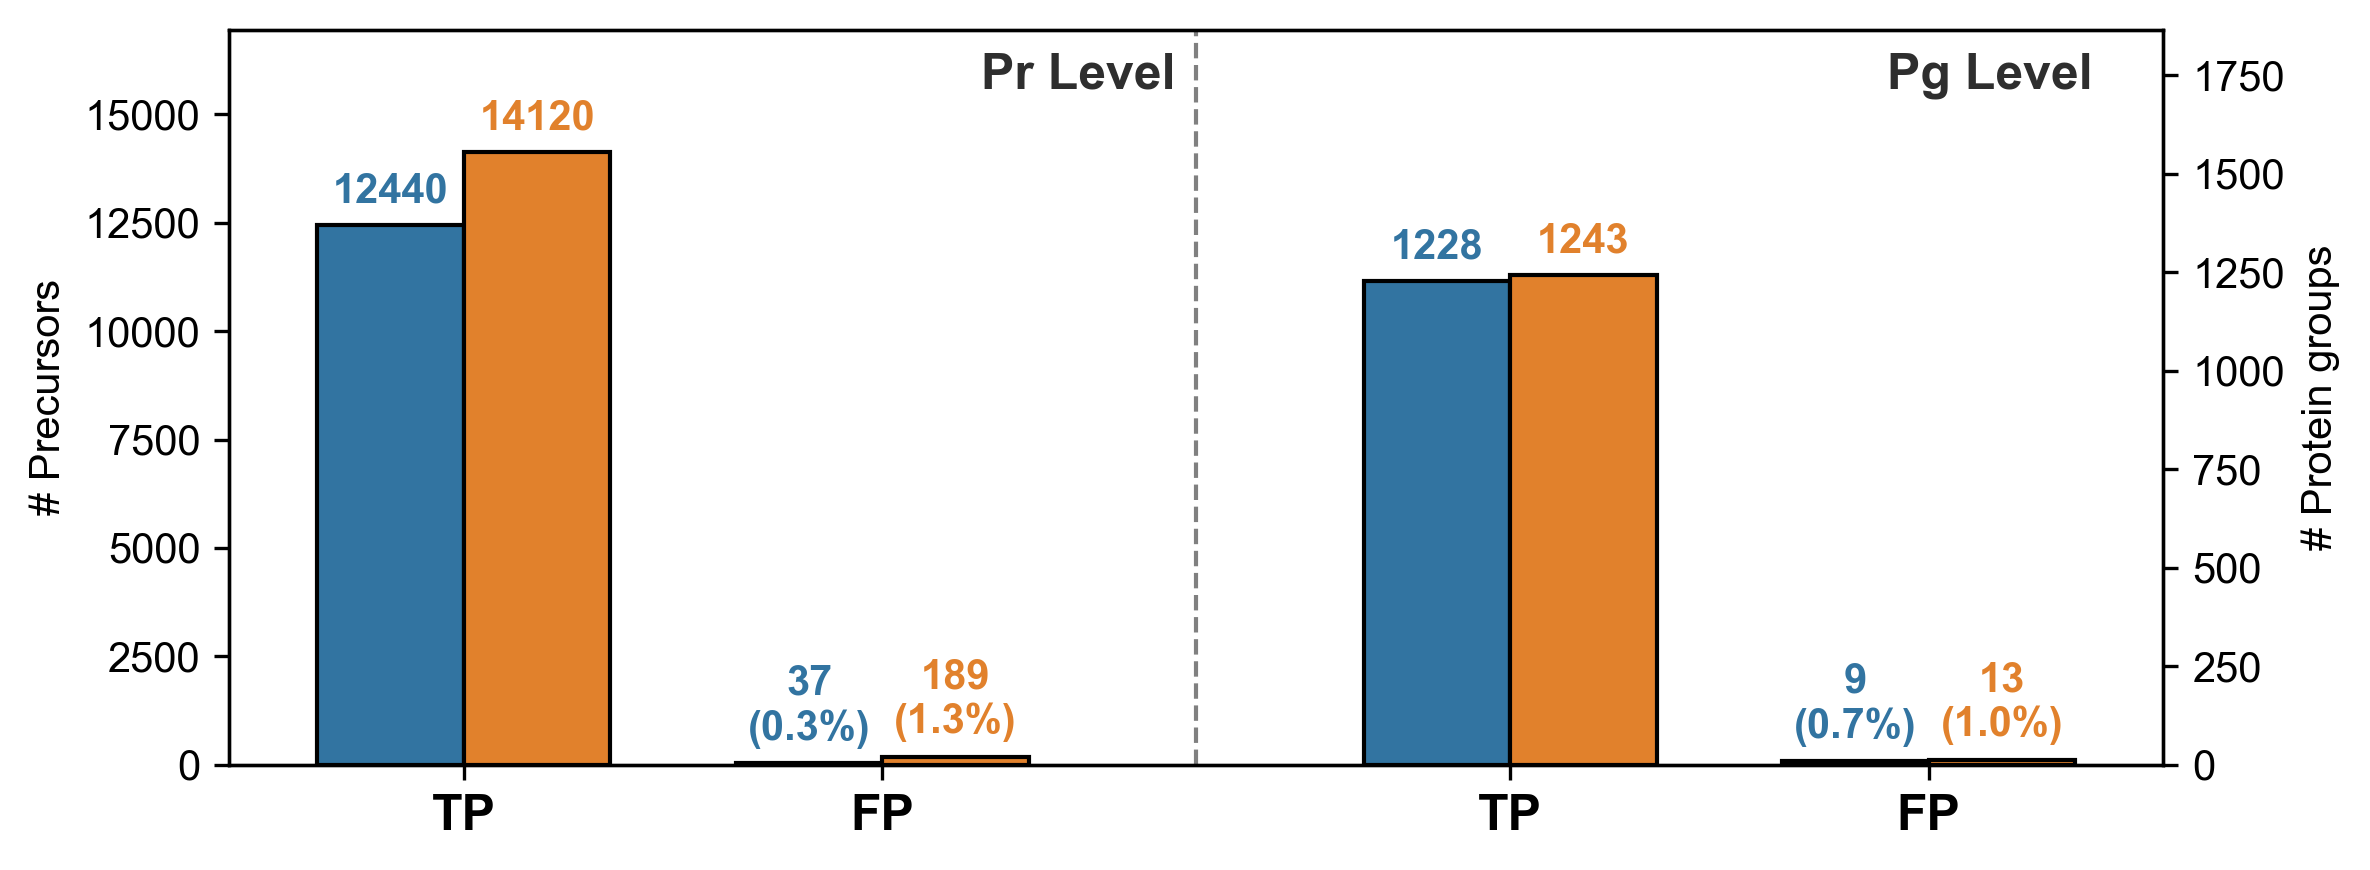

In [8]:
# plot
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
method_colors = {'diann': '#3274a1', 'fulldia': '#e1812c'}

ax1 = ax
ax2 = ax1.twinx()

peptide_max = df_plot[df_plot["Level"] == "pr"]["Count"].max()
protein_max = df_plot[df_plot["Level"] == "pg"]["Count"].max()
ax1.set_ylim(0, peptide_max * 1.2)
ax2.set_ylim(0, protein_max * 1.5)
ax1.set_ylabel('# Precursors')
ax2.set_ylabel('# Protein groups')

x_groups = {"pr_TP": 0, "pr_FP": 1, "pg_TP": 2.5, "pg_FP": 3.5}
width = 0.35

for (method, level_metric), grp in df_plot.groupby(
        ["Method", "Level_Metric"]
):
    level, metric = level_metric.split("_")
    ax = ax1 if level == "pr" else ax2

    # pos
    base_x = x_groups[f"{level}_{metric}"]
    offset = -width / 2 if method == "diann" else width / 2
    x = base_x + offset

    # bar
    bar = ax.bar(
        x, grp["Count"].values[0],
        width=width,
        color=method_colors[method],
        edgecolor="k",
    )

    # text values
    label_y = grp["Count"].values[0] + (0.02 * ax.get_ylim()[1])
    ax.text(
        x, label_y, f"{grp['Display_Value'].values[0]}",
        ha="center", va="bottom",
        color=method_colors[method],
        fontsize=10,
        weight='bold'
    )

ax1.set_xticks(list(x_groups.values()))
ax1.set_xticklabels(["TP", "FP", "TP", "FP"],
                    fontsize=12,
                    weight='bold')
ax1.axvline(1.75, color="gray", ls="--", lw=1)
ax1.text(1.7, ax1.get_ylim()[1] * 0.97, "Pr Level",
         ha="right", va="top",
         fontsize=12, weight='bold', color='#2e2e2e')
ax1.text(3.4, ax1.get_ylim()[1] * 0.97, "Pg Level",
         ha="left", va="top",
         fontsize=12, weight='bold', color='#2e2e2e')
plt.tight_layout()
plt.show()

In [9]:
# matrix: df_pr1
df_pr1 = df_raw1[(df_raw1['Global.Q.Value'] < 0.01) &
                 (df_raw1['Q.Value'] < 0.01)]
df_pr1 = df_pr1[['Run', 'Precursor.Id', 'Precursor.Quantity']]
df_pr1 = df_pr1.drop_duplicates().reset_index(drop=True)
df_pr1 = df_pr1.pivot(index='Precursor.Id', columns='Run', values='Precursor.Quantity')
df_pr1 = df_pr1.fillna(0.)
df_pr1.columns.name = None
df_pr1.index.name = None
# print(df_pr1.columns)
df_pr1.copy()

,PIQ001_EVOSEP01_TIMS04_PRO_HT_BOB2_NP5_Pooled_Loading_Curve_30SPD_0011_S3-A7_1_462,PIQ001_EVOSEP01_TIMS04_PRO_HT_BOB2_NP5_Pooled_Loading_Curve_30SPD_0012_S3-B7_1_463,PIQ001_EVOSEP01_TIMS04_PRO_HT_BOB2_NP5_Pooled_Loading_Curve_30SPD_0013_S3-C7_1_464,PIQ001_EVOSEP01_TIMS04_PRO_HT_BOB2_NP5_Pooled_Loading_Curve_30SPD_0015_S3-D7_1_466,PIQ001_EVOSEP01_TIMS04_PRO_HT_BOB2_NP5_Pooled_Loading_Curve_30SPD_0017_S3-E7_1_468,PIQ001_EVOSEP01_TIMS04_PRO_HT_BOB2_NP5_Pooled_Loading_Curve_30SPD_0027_S3-A8_1_478,PIQ001_EVOSEP01_TIMS04_PRO_HT_BOB2_NP5_Pooled_Loading_Curve_30SPD_0028_S3-B8_1_479,PIQ001_EVOSEP01_TIMS04_PRO_HT_BOB2_NP5_Pooled_Loading_Curve_30SPD_0029_S3-C8_1_480,PIQ001_EVOSEP01_TIMS04_PRO_HT_BOB2_NP5_Pooled_Loading_Curve_30SPD_0031_S3-D8_1_482,PIQ001_EVOSEP01_TIMS04_PRO_HT_BOB2_NP5_Pooled_Loading_Curve_30SPD_0033_S3-E8_1_484,PIQ001_EVOSEP01_TIMS04_PRO_HT_BOB2_NP5_Pooled_Loading_Curve_30SPD_0043_S3-A9_1_494,PIQ001_EVOSEP01_TIMS04_PRO_HT_BOB2_NP5_Pooled_Loading_Curve_30SPD_0044_S3-B9_1_495,PIQ001_EVOSEP01_TIMS04_PRO_HT_BOB2_NP5_Pooled_Loading_Curve_30SPD_0045_S3-C9_1_496,PIQ001_EVOSEP01_TIMS04_PRO_HT_BOB2_NP5_Pooled_Loading_Curve_30SPD_0047_S3-D9_1_498,PIQ001_EVOSEP01_TIMS04_PRO_HT_BOB2_NP5_Pooled_Loading_Curve_30SPD_0049_S3-E9_1_500
AAAATGTIFTFR2,1.500180e+04,6.375797e+04,1.121304e+05,1.305808e+05,1.161247e+05,2.497698e+04,7.216451e+04,9.891337e+04,1.106577e+05,1.333469e+05,2.577911e+04,6.479419e+04,9.590747e+04,1.373134e+05,8.916069e+04
AAAEVAGQFVIK2,9.531126e+03,1.504988e+05,3.959556e+05,6.134379e+05,6.895600e+05,5.521216e+04,1.419120e+05,4.569137e+05,5.081939e+05,7.144952e+05,5.281950e+04,2.351573e+05,4.028086e+05,4.968003e+05,7.380008e+05
AAAFEEQENETVVVK2,2.984556e+05,5.032144e+05,3.787958e+05,5.574532e+04,0.000000e+00,2.212549e+05,0.000000e+00,2.342170e+05,0.000000e+00,0.000000e+00,2.457570e+05,0.000000e+00,1.400212e+05,0.000000e+00,0.000000e+00
AAAFLGDIALDEEDLR2,0.000000e+00,6.431259e+03,1.131128e+04,2.522385e+04,4.683862e+04,0.000000e+00,5.930297e+03,1.113323e+04,1.718332e+04,3.056935e+04,0.000000e+00,4.472924e+03,1.049647e+04,2.324076e+04,3.037311e+04
AAAITSDILEALGR2,3.339395e+03,1.775067e+04,5.572963e+04,8.685660e+04,1.335662e+05,5.065888e+03,1.978179e+04,5.456337e+04,9.969424e+04,1.167425e+05,1.986468e+03,8.848218e+03,4.684454e+04,8.950227e+04,1.076325e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YYVTIIDAPGHRDFIK3,0.000000e+00,7.862791e+03,1.190637e+04,1.926450e+04,1.974047e+04,1.917940e+03,7.641976e+03,9.388735e+03,1.642018e+04,2.730049e+04,0.000000e+00,8.006750e+03,1.638804e+04,1.982394e+04,2.200646e+04
YYWGGQYTWDM(UniMod:35)AK2,8.599259e+06,2.009481e+07,2.754540e+07,2.613458e+07,2.707260e+07,1.141840e+07,2.201775e+07,2.805563e+07,2.440669e+07,2.368526e+07,1.269158e+07,2.433789e+07,2.171804e+07,2.746624e+07,2.439727e+07
YYWGGQYTWDM(UniMod:35)AK3,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,8.730559e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.373792e+04,1.656312e+04
YYWGGQYTWDMAK2,2.337540e+07,4.491645e+07,2.807433e+06,4.083444e+07,5.066250e+07,2.859632e+07,2.709546e+07,3.398809e+07,4.712914e+07,5.202276e+07,2.639979e+07,4.025140e+07,4.613367e+07,4.395032e+07,5.432987e+07


In [10]:
# matrix: df_pr2
df_pr2 = df_raw2[(df_raw2['Global.Q.Value'] < 0.01)]
df_pr2 = df_pr2[['Run', 'Precursor.Id', 'Precursor.Quantity.Deep']]
df_pr2 = df_pr2.drop_duplicates().reset_index(drop=True)
df_pr2 = df_pr2.pivot(index='Precursor.Id', columns='Run', values='Precursor.Quantity.Deep')
df_pr2 = df_pr2.fillna(0.)
df_pr2.columns.name = None
df_pr2.index.name = None
df_pr2.copy()

,PIQ001_EVOSEP01_TIMS04_PRO_HT_BOB2_NP5_Pooled_Loading_Curve_30SPD_0011_S3-A7_1_462,PIQ001_EVOSEP01_TIMS04_PRO_HT_BOB2_NP5_Pooled_Loading_Curve_30SPD_0012_S3-B7_1_463,PIQ001_EVOSEP01_TIMS04_PRO_HT_BOB2_NP5_Pooled_Loading_Curve_30SPD_0013_S3-C7_1_464,PIQ001_EVOSEP01_TIMS04_PRO_HT_BOB2_NP5_Pooled_Loading_Curve_30SPD_0015_S3-D7_1_466,PIQ001_EVOSEP01_TIMS04_PRO_HT_BOB2_NP5_Pooled_Loading_Curve_30SPD_0017_S3-E7_1_468,PIQ001_EVOSEP01_TIMS04_PRO_HT_BOB2_NP5_Pooled_Loading_Curve_30SPD_0027_S3-A8_1_478,PIQ001_EVOSEP01_TIMS04_PRO_HT_BOB2_NP5_Pooled_Loading_Curve_30SPD_0028_S3-B8_1_479,PIQ001_EVOSEP01_TIMS04_PRO_HT_BOB2_NP5_Pooled_Loading_Curve_30SPD_0029_S3-C8_1_480,PIQ001_EVOSEP01_TIMS04_PRO_HT_BOB2_NP5_Pooled_Loading_Curve_30SPD_0031_S3-D8_1_482,PIQ001_EVOSEP01_TIMS04_PRO_HT_BOB2_NP5_Pooled_Loading_Curve_30SPD_0033_S3-E8_1_484,PIQ001_EVOSEP01_TIMS04_PRO_HT_BOB2_NP5_Pooled_Loading_Curve_30SPD_0043_S3-A9_1_494,PIQ001_EVOSEP01_TIMS04_PRO_HT_BOB2_NP5_Pooled_Loading_Curve_30SPD_0044_S3-B9_1_495,PIQ001_EVOSEP01_TIMS04_PRO_HT_BOB2_NP5_Pooled_Loading_Curve_30SPD_0045_S3-C9_1_496,PIQ001_EVOSEP01_TIMS04_PRO_HT_BOB2_NP5_Pooled_Loading_Curve_30SPD_0047_S3-D9_1_498,PIQ001_EVOSEP01_TIMS04_PRO_HT_BOB2_NP5_Pooled_Loading_Curve_30SPD_0049_S3-E9_1_500
AAAAAAALQAK2,4.601870e+03,7.026155e+03,1.133165e+04,1.011906e+04,1.373250e+04,3.706971e+03,7.030137e+03,1.048384e+04,1.324313e+04,1.495530e+04,4.145816e+03,7.173104e+03,9.497644e+03,1.161344e+04,1.203967e+04
AAAATGTIFTFR2,1.834244e+04,4.367441e+04,1.252515e+05,1.235267e+05,1.228913e+05,1.978354e+04,6.073909e+04,1.291945e+05,1.574569e+05,9.115491e+04,2.099037e+04,6.271817e+04,1.122798e+05,1.455093e+05,1.329579e+05
AAAEVAGQFVIK2,3.460282e+04,1.379272e+05,1.948129e+05,2.712047e+05,3.581224e+05,3.844646e+04,1.380828e+05,2.052927e+05,3.183014e+05,4.651720e+05,3.724557e+04,9.708169e+04,1.923175e+05,3.579982e+05,3.351198e+05
AAAFEEQENETVVVK2,2.590634e+04,4.052741e+04,3.302689e+04,2.032774e+04,1.925262e+04,2.089639e+04,3.350494e+04,2.163737e+04,2.464662e+04,3.377971e+04,2.536198e+04,3.164488e+04,2.416999e+04,2.940316e+04,1.822374e+04
AAAFLGDIALDEEDLR2,7.777851e+03,2.069746e+04,4.642868e+04,2.731189e+04,3.337898e+04,6.694768e+03,3.042844e+04,5.640008e+04,5.242325e+04,3.130998e+04,6.810209e+03,2.193352e+04,3.982837e+04,4.236709e+04,3.517999e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YYVTIIDAPGHRDFIK3,7.801261e+03,2.176506e+04,3.671879e+04,3.876634e+04,5.207986e+04,8.049889e+03,2.363866e+04,3.766011e+04,4.894163e+04,5.948416e+04,7.967334e+03,1.915039e+04,3.248265e+04,4.387697e+04,4.694875e+04
YYWGGQYTWDM(UniMod:35)AK2,6.653136e+05,2.086296e+06,5.714890e+06,5.722947e+06,3.863092e+06,7.106452e+05,2.418841e+06,6.238977e+06,7.193622e+06,6.412662e+05,7.395771e+05,2.825204e+06,5.020800e+06,5.369130e+06,6.773034e+06
YYWGGQYTWDM(UniMod:35)AK3,3.847537e+03,7.516817e+03,1.175256e+04,1.090582e+04,1.501747e+04,3.590626e+03,8.216364e+03,1.190646e+04,1.519670e+04,2.022324e+04,3.491626e+03,6.736104e+03,1.050045e+04,1.419727e+04,1.376670e+04
YYWGGQYTWDMAK2,1.390258e+06,3.008773e+06,4.131452e+06,4.067944e+06,4.011382e+06,1.552978e+06,3.294244e+06,4.257588e+06,3.869538e+06,3.373177e+06,1.713003e+06,3.560182e+06,4.214301e+06,4.840604e+06,3.883334e+06


In [11]:
# matrix: df_pg1
df_pg1 = df_raw1[(df_raw1['Global.PG.Q.Value'] < 0.01) &
                 (df_raw1['PG.Q.Value'] < 0.01)]
df_pg1 = df_pg1[['Run', 'Protein.Group', 'PG.MaxLFQ']]
df_pg1 = df_pg1.drop_duplicates().reset_index(drop=True)
df_pg1 = df_pg1.pivot(index='Protein.Group', columns='Run', values='PG.MaxLFQ')
df_pg1 = df_pg1.fillna(0.)
df_pg1.columns.name = None
df_pg1.index.name = None
df_pg1.copy()

,PIQ001_EVOSEP01_TIMS04_PRO_HT_BOB2_NP5_Pooled_Loading_Curve_30SPD_0011_S3-A7_1_462,PIQ001_EVOSEP01_TIMS04_PRO_HT_BOB2_NP5_Pooled_Loading_Curve_30SPD_0012_S3-B7_1_463,PIQ001_EVOSEP01_TIMS04_PRO_HT_BOB2_NP5_Pooled_Loading_Curve_30SPD_0013_S3-C7_1_464,PIQ001_EVOSEP01_TIMS04_PRO_HT_BOB2_NP5_Pooled_Loading_Curve_30SPD_0015_S3-D7_1_466,PIQ001_EVOSEP01_TIMS04_PRO_HT_BOB2_NP5_Pooled_Loading_Curve_30SPD_0017_S3-E7_1_468,PIQ001_EVOSEP01_TIMS04_PRO_HT_BOB2_NP5_Pooled_Loading_Curve_30SPD_0027_S3-A8_1_478,PIQ001_EVOSEP01_TIMS04_PRO_HT_BOB2_NP5_Pooled_Loading_Curve_30SPD_0028_S3-B8_1_479,PIQ001_EVOSEP01_TIMS04_PRO_HT_BOB2_NP5_Pooled_Loading_Curve_30SPD_0029_S3-C8_1_480,PIQ001_EVOSEP01_TIMS04_PRO_HT_BOB2_NP5_Pooled_Loading_Curve_30SPD_0031_S3-D8_1_482,PIQ001_EVOSEP01_TIMS04_PRO_HT_BOB2_NP5_Pooled_Loading_Curve_30SPD_0033_S3-E8_1_484,PIQ001_EVOSEP01_TIMS04_PRO_HT_BOB2_NP5_Pooled_Loading_Curve_30SPD_0043_S3-A9_1_494,PIQ001_EVOSEP01_TIMS04_PRO_HT_BOB2_NP5_Pooled_Loading_Curve_30SPD_0044_S3-B9_1_495,PIQ001_EVOSEP01_TIMS04_PRO_HT_BOB2_NP5_Pooled_Loading_Curve_30SPD_0045_S3-C9_1_496,PIQ001_EVOSEP01_TIMS04_PRO_HT_BOB2_NP5_Pooled_Loading_Curve_30SPD_0047_S3-D9_1_498,PIQ001_EVOSEP01_TIMS04_PRO_HT_BOB2_NP5_Pooled_Loading_Curve_30SPD_0049_S3-E9_1_500
A0A075B6H9,4.371997e+03,2.780010e+04,9.059691e+04,1.434208e+05,1.572564e+05,0.000000e+00,3.524834e+04,9.272795e+04,1.514818e+05,1.526434e+05,0.000000e+00,2.875644e+04,6.376601e+04,1.182747e+05,1.324449e+05
A0A075B6I1,0.000000e+00,0.000000e+00,1.534816e+04,2.349055e+04,3.481350e+04,0.000000e+00,9.858087e+03,1.718890e+04,2.305728e+04,4.057384e+04,0.000000e+00,0.000000e+00,0.000000e+00,1.867349e+04,0.000000e+00
A0A075B6J9,0.000000e+00,0.000000e+00,2.625960e+04,4.051240e+04,4.627736e+04,5.723442e+03,1.678796e+04,3.402949e+04,3.933329e+04,5.226725e+04,0.000000e+00,0.000000e+00,3.124067e+04,4.013983e+04,5.060002e+04
A0A075B6K0,3.549758e+04,1.714987e+05,1.816344e+05,1.472501e+05,9.287877e+04,6.956135e+04,1.704433e+05,2.063258e+05,1.699142e+05,9.797309e+04,4.984928e+04,1.053242e+05,1.879409e+05,1.419532e+05,7.986054e+04
A0A075B6K4,5.952082e+04,1.364641e+05,3.063117e+05,4.296446e+05,4.710964e+05,6.928202e+04,2.016958e+05,2.999440e+05,4.009284e+05,4.220780e+05,6.239145e+04,1.719979e+05,2.700410e+05,3.333872e+05,4.291104e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q9Y6E0,0.000000e+00,9.328411e+03,2.186882e+04,3.638604e+04,4.412345e+04,1.027544e+04,1.090728e+04,2.171712e+04,3.582707e+04,3.458789e+04,0.000000e+00,8.308878e+03,1.891579e+04,2.976646e+04,3.534619e+04
Q9Y6L7,2.535109e+05,6.167868e+05,1.303942e+06,1.970478e+06,2.102534e+06,1.873981e+05,7.080369e+05,1.436435e+06,1.946895e+06,2.022347e+06,2.191884e+05,7.685445e+05,1.316300e+06,1.896375e+06,2.087321e+06
Q9Y6R7,2.005253e+04,5.689955e+04,1.086027e+05,1.515399e+05,1.484480e+05,2.496656e+04,6.761023e+04,1.142817e+05,1.345990e+05,1.346448e+05,2.530498e+04,6.202617e+04,1.063278e+05,1.394606e+05,1.464704e+05
Q9Y6Y8,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.263654e+04,7.660584e+04,0.000000e+00,0.000000e+00,1.366388e+04,0.000000e+00,0.000000e+00,6.142672e+04


In [12]:
# matrix: df_pg2
df_pg2 = df_raw2[(df_raw2['Global.PG.Q.Value'] < 0.01)]
df_pg2 = df_pg2[['Run', 'Protein.Group', 'PG.Quantity.Deep']]
df_pg2 = df_pg2.drop_duplicates().reset_index(drop=True)
df_pg2 = df_pg2.pivot(index='Protein.Group', columns='Run', values='PG.Quantity.Deep')
df_pg2 = df_pg2.fillna(0.)
df_pg2.columns.name = None
df_pg2.index.name = None
df_pg2.copy()

,PIQ001_EVOSEP01_TIMS04_PRO_HT_BOB2_NP5_Pooled_Loading_Curve_30SPD_0011_S3-A7_1_462,PIQ001_EVOSEP01_TIMS04_PRO_HT_BOB2_NP5_Pooled_Loading_Curve_30SPD_0012_S3-B7_1_463,PIQ001_EVOSEP01_TIMS04_PRO_HT_BOB2_NP5_Pooled_Loading_Curve_30SPD_0013_S3-C7_1_464,PIQ001_EVOSEP01_TIMS04_PRO_HT_BOB2_NP5_Pooled_Loading_Curve_30SPD_0015_S3-D7_1_466,PIQ001_EVOSEP01_TIMS04_PRO_HT_BOB2_NP5_Pooled_Loading_Curve_30SPD_0017_S3-E7_1_468,PIQ001_EVOSEP01_TIMS04_PRO_HT_BOB2_NP5_Pooled_Loading_Curve_30SPD_0027_S3-A8_1_478,PIQ001_EVOSEP01_TIMS04_PRO_HT_BOB2_NP5_Pooled_Loading_Curve_30SPD_0028_S3-B8_1_479,PIQ001_EVOSEP01_TIMS04_PRO_HT_BOB2_NP5_Pooled_Loading_Curve_30SPD_0029_S3-C8_1_480,PIQ001_EVOSEP01_TIMS04_PRO_HT_BOB2_NP5_Pooled_Loading_Curve_30SPD_0031_S3-D8_1_482,PIQ001_EVOSEP01_TIMS04_PRO_HT_BOB2_NP5_Pooled_Loading_Curve_30SPD_0033_S3-E8_1_484,PIQ001_EVOSEP01_TIMS04_PRO_HT_BOB2_NP5_Pooled_Loading_Curve_30SPD_0043_S3-A9_1_494,PIQ001_EVOSEP01_TIMS04_PRO_HT_BOB2_NP5_Pooled_Loading_Curve_30SPD_0044_S3-B9_1_495,PIQ001_EVOSEP01_TIMS04_PRO_HT_BOB2_NP5_Pooled_Loading_Curve_30SPD_0045_S3-C9_1_496,PIQ001_EVOSEP01_TIMS04_PRO_HT_BOB2_NP5_Pooled_Loading_Curve_30SPD_0047_S3-D9_1_498,PIQ001_EVOSEP01_TIMS04_PRO_HT_BOB2_NP5_Pooled_Loading_Curve_30SPD_0049_S3-E9_1_500
A0A075B6H9,4667.421875,2.342516e+04,7.920083e+04,1.240570e+05,1.908438e+05,5245.519531,2.773903e+04,8.431745e+04,1.620517e+05,2.054731e+05,4687.132812,2.087552e+04,7.396666e+04,1.392744e+05,1.634284e+05
A0A075B6I1,7191.786621,7.209720e+03,1.532788e+04,1.686578e+04,1.727571e+04,6247.833984,7.935245e+03,1.199608e+04,1.480475e+04,1.269371e+04,8386.084961,1.093288e+04,1.320531e+04,1.407327e+04,1.728485e+04
A0A075B6J9,26740.324219,4.971818e+04,7.460889e+04,7.984448e+04,8.659115e+04,28429.480469,5.448340e+04,6.714912e+04,7.784609e+04,8.421008e+04,30157.451172,5.509914e+04,6.824866e+04,8.028895e+04,8.171585e+04
A0A075B6K4,86584.828125,1.545059e+05,1.622334e+05,1.404332e+05,1.381951e+05,90491.757812,1.685012e+05,1.600831e+05,1.388813e+05,1.679870e+05,94361.445312,1.555871e+05,1.520842e+05,1.558418e+05,1.261373e+05
A0A075B6K5,68059.437500,2.158175e+05,4.717666e+05,6.251186e+05,6.711559e+05,86406.562500,2.494180e+05,4.417961e+05,6.385436e+05,6.108072e+05,82639.671875,2.354522e+05,4.278292e+05,6.466346e+05,6.322644e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q9Y6L7,329811.687500,1.386436e+06,3.255902e+06,4.134854e+06,4.908339e+06,409697.562500,1.548568e+06,3.175372e+06,4.548700e+06,4.363819e+06,401358.218750,1.425693e+06,2.926620e+06,4.496980e+06,4.447217e+06
Q9Y6R7,71560.015625,1.792500e+05,2.897531e+05,2.915251e+05,3.212233e+05,81604.937500,1.972397e+05,2.761832e+05,3.077714e+05,3.218612e+05,81739.000000,1.904767e+05,2.539402e+05,3.149966e+05,2.820933e+05
Q9Y6Y8,10016.121094,2.807818e+04,8.160953e+04,1.086129e+05,1.268580e+05,10873.072266,3.486036e+04,8.006358e+04,1.235998e+05,1.077234e+05,11265.953125,3.529389e+04,7.385956e+04,1.108555e+05,1.240171e+05
Q9Y6Z7,5913.147461,3.649030e+04,6.807798e+04,9.962771e+04,1.571351e+05,8054.922363,3.698704e+04,6.769216e+04,1.204496e+05,2.310111e+05,5531.911133,2.134653e+04,6.221532e+04,1.228962e+05,1.368036e+05


In [13]:
# pcc
def cal_pcc_rowwise(x, loads):
    y = np.tile(loads, (len(x), 1))
    x_c = x - x.mean(axis=1, keepdims=True)
    y_c = y - y.mean(axis=1, keepdims=True)
    numerator = np.sum(x_c * y_c, axis=1)
    x_std = np.sqrt(np.sum(x_c**2, axis=1))
    y_std = np.sqrt(np.sum(y_c**2, axis=1))
    denominator = x_std * y_std
    return numerator / (denominator + 1e-6)

loads = np.array([1, 3, 6, 9, 12] * 3)
pr_pcc1 = cal_pcc_rowwise(df_pr1.values, loads)
pr_pcc2 = cal_pcc_rowwise(df_pr2.values, loads)
pg_pcc1 = cal_pcc_rowwise(df_pg1.values, loads)
pg_pcc2 = cal_pcc_rowwise(df_pg2.values, loads)

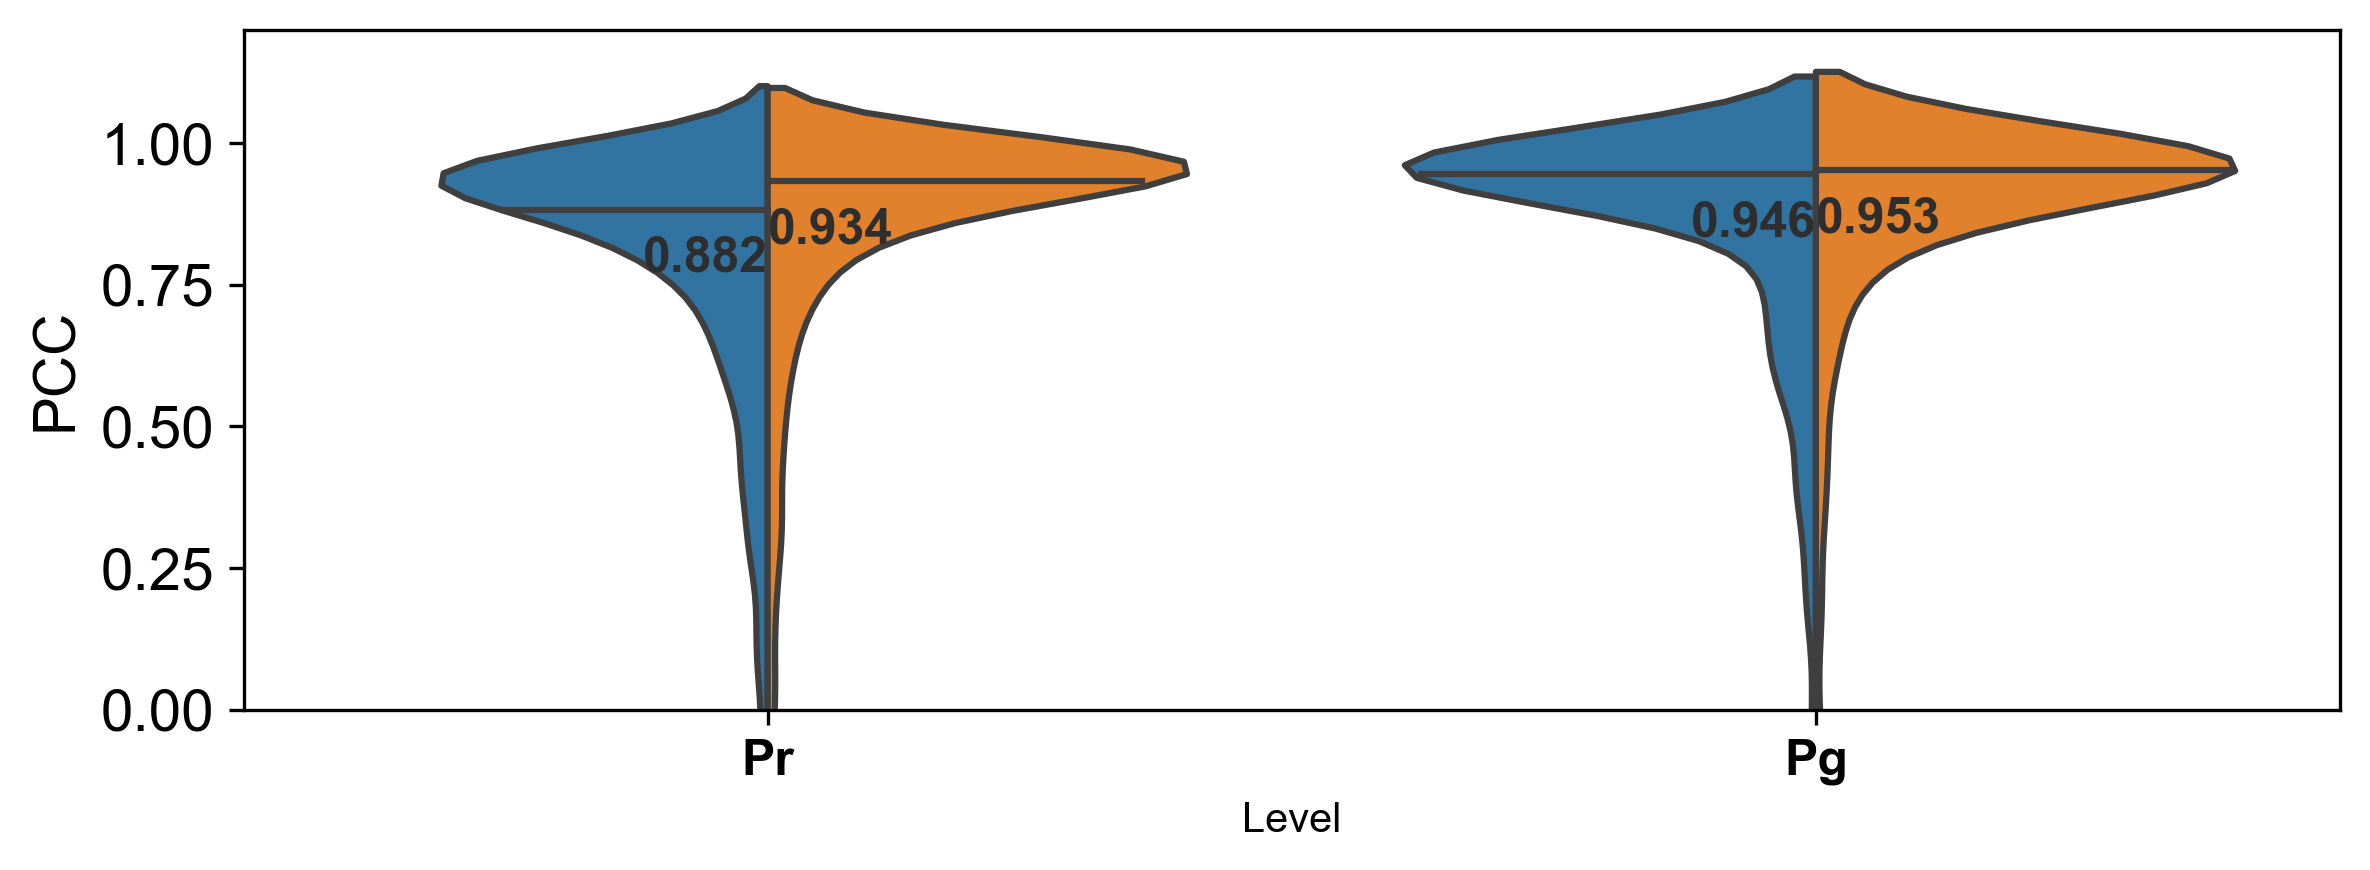

In [14]:
# plot pcc
from seaborn.categorical import _ViolinPlotter
class MyVPlot(_ViolinPlotter):
    def draw_quartiles(self, ax, data, support, density, center, split=False):
        """Draw the quartiles as lines at width of density."""
        q25, q50, q75 = np.percentile(data, [25, 50, 75])
        # print(q50)
        self.draw_to_density(ax, center, q50, support, density, split,
                             linewidth=self.linewidth, )

def my_violinplot(x=None, y=None, hue=None, data=None, order=None, hue_order=None,
                  bw="scott", cut=2, scale="area", scale_hue=True, gridsize=100,
                  width=.8, inner="box", split=False, dodge=True, orient=None,
                  linewidth=None, color=None, palette=None, satuRation=0.75,
                  ax=None, **kwargs):
    plotter = MyVPlot(x, y, hue, data, order, hue_order,
                      bw, cut, scale, scale_hue, gridsize,
                      width, inner, split, dodge, orient, linewidth,
                      color, palette, satuRation)
    if ax is None:
        ax = plt.gca()

    plotter.plot(ax)
    return ax

fig, ax = plt.subplots(1, 1, figsize=(8, 3))

df_violin_pr = pd.DataFrame()
df_violin_pr['PCC'] = np.concatenate([pr_pcc1, pr_pcc2])
df_violin_pr['Method'] = ['diann'] * len(pr_pcc1) + ['full'] * len(pr_pcc2)
df_violin_pr['Level'] = ['Pr'] * len(df_violin_pr)

df_violin_pg = pd.DataFrame()
df_violin_pg['PCC'] = np.concatenate([pg_pcc1, pg_pcc2])
df_violin_pg['Method'] = ['diann'] * len(pg_pcc1) + ['full'] * len(pg_pcc2)
df_violin_pg['Level'] = ['Pg'] * len(df_violin_pg)

df_violin = pd.concat([df_violin_pr, df_violin_pg], axis=0, ignore_index=True)
ax_tmp = my_violinplot(data=df_violin,
                       x='Level',
                       y='PCC',
                       hue='Method',
                       split=True,
                       inner="quartiles",
                       ax=ax,
                       # cut=0
)
x1, x2 = np.median(pr_pcc1), np.median(pr_pcc2)
x3, x4 = np.median(pg_pcc1), np.median(pg_pcc2)
ax.text(0., x1*0.95, f'{x1:.3f}',
         ha="right", va="top",
         fontsize=12, weight='bold', color='#2e2e2e')
ax.text(0., x2 * 0.95, f'{x2:.3f}',
        ha="left", va="top",
        fontsize=12, weight='bold', color='#2e2e2e')
ax.text(1., x3 * 0.95, f'{x3:.3f}',
        ha="right", va="top",
        fontsize=12, weight='bold', color='#2e2e2e')
ax.text(1., x4 * 0.95, f'{x4:.3f}',
        ha="left", va="top",
        fontsize=12, weight='bold', color='#2e2e2e')
ax.set_ylim([0, 1.2])
ax.set_xticklabels(['Pr', 'Pg'],
                    fontsize=12,
                    weight='bold')
ax.tick_params(axis='y', labelsize=14)
ax.set_ylabel("PCC", fontsize=14)
ax.legend_.remove()
plt.tight_layout()
plt.show()